# Figure 3 – Verger-Miralles et al. (2025)

**SWOT enhances small-scale eddy detection in the Mediterranean Sea**

Author: *Elisabet Verger-Miralles*  
Institution: IMEDEA (CSIC-UIB)

In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.gridspec   as gridspec
from matplotlib              import dates as mdates
from datetime                import datetime, timedelta
import scipy.io
from scipy.interpolate import griddata
import cartopy.crs           as ccrs
import cartopy.feature       as cfeature
import gsw
import cmocean
from functions import *

## Load the data

### GLIDER

In [2]:
dir_file = '../../grl_codes_to_publish_def_swotv2.0.1/data/glider/'

file_path = 'glider09_section4_fast_swot.nc'

ds = xr.open_dataset(dir_file+file_path)

Extract variables:

In [3]:
# Extract the variables
Lon = ds.lon.squeeze()
Lat = ds.lat.squeeze()
t = ds.glider_time.values.squeeze()

t = [datetime.utcfromtimestamp(ts.astype('O') / 1e9) for ts in t] 


dh_700 = ds.dh_700.squeeze()

# COMPUTE ANOMALY
dh_an_glider = dh_700-np.nanmean(dh_700)

**Define the area:**

In [4]:
lon_min = Lon.min()-.15
lon_max = Lon.max()+.15
lat_min = Lat.min()-.15
lat_max = Lat.max()+.15

### SWOT 

In [5]:
dir_SWOT = '../../grl_codes_to_publish_def_swotv2.0.1/data/SWOT/'
files_sw = np.sort(glob.glob(dir_SWOT+'*016_202305*v2*.nc')) # from May 4 to May 6 2023
print(files_sw)

['../../grl_codes_to_publish_def_swotv2.0.1/data/SWOT\\SWOT_L3_LR_SSH_Expert_510_016_20230504T051114_20230504T060218_v2.0.1.nc'
 '../../grl_codes_to_publish_def_swotv2.0.1/data/SWOT\\SWOT_L3_LR_SSH_Expert_511_016_20230505T050152_20230505T055256_v2.0.1.nc'
 '../../grl_codes_to_publish_def_swotv2.0.1/data/SWOT\\SWOT_L3_LR_SSH_Expert_512_016_20230506T045229_20230506T054334_v2.0.1.nc']


In [6]:
# Process and concatenate dataframes 
df_swot = None  
for file in files_sw:
  ds_SWOT = xr.open_dataset(file)
  df_swot = process_and_concat_swot(ds_SWOT,lon_min, lon_max, lat_min, lat_max, df_swot)

Extract ds to plot the map May 5th:

In [7]:
ds_SWOT = xr.open_dataset(files_sw[1])

# cut the data to the region of interest 

ds_SWOT = ds_SWOT.where((ds_SWOT['longitude'] < 1.9) & (ds_SWOT['longitude'] > 1))
ds_SWOT = ds_SWOT.where((ds_SWOT['latitude'] < 40.5) & (ds_SWOT['latitude'] > 39.3))
ds_SWOT

<xarray.Dataset> Size: 7GB
Dimensions:               (num_lines: 9860, num_pixels: 69, num_nadir: 1344)
Coordinates:
    latitude              (num_lines, num_pixels) float64 5MB 78.27 ... -78.27
    longitude             (num_lines, num_pixels) float64 5MB 286.1 ... 92.99
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/21)
    time                  (num_lines, num_pixels) datetime64[ns] 5MB NaT ... NaT
    calibration           (num_lines, num_pixels) float64 5MB nan nan ... nan
    cross_track_distance  (num_pixels, num_lines) float64 5MB nan nan ... nan
    dac                   (num_lines, num_pixels) float64 5MB nan nan ... nan
    internal_tide         (num_lines, num_pixels) float64 5MB nan nan ... nan
    mdt                   (num_lines, num_pixels) float64 5MB nan nan ... nan
    ...                    ...
    ugosa_unfiltered      (num_lines, num_pixels) float64 5MB nan nan ... nan
    vgos_filtered         (num_lines, num_pixels) float64 5MB nan nan ... nan
    vgosa_filtered        (num_lines, num_pixels) float64 5MB nan nan ... nan
    vgosa_unfiltered      (num_lines, num_pixels) float64 5MB nan nan ... nan
    i_num_line            (num_nadir, num_lines, num_pixels) float32 4GB nan ...
    i_num_pixel           (num_nadir, num_lines, num_pixels) float32 4GB nan ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0/PIC2 (NAS...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              6.5e-05
    geospatial_lon_max:              359.999908
    date_modified:                   2025-03-04T18:31:26Z
    history:                         2025-03-04T18:31:26Z: Created by DUACS K...
    date_created:                    2025-03-04T18:31:26Z
    date_issued:                     2025-03-04T18:31:26Z

In [8]:
# ADT SWOT anomaly
adt_swot = (ds_SWOT.ssha_filtered+ds_SWOT.mdt) - np.nanmean(ds_SWOT.ssha_filtered+ds_SWOT.mdt)
adt_swot

<xarray.DataArray (num_lines: 9860, num_pixels: 69)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(9860, 69))
Coordinates:
    latitude   (num_lines, num_pixels) float64 5MB 78.27 78.25 ... -78.25 -78.27
    longitude  (num_lines, num_pixels) float64 5MB 286.1 286.1 ... 92.99 92.99
Dimensions without coordinates: num_lines, num_pixels

### DUACS

In [13]:
dir_DUACS = '../../grl_codes_to_publish_def_swotv2.0.1/data/DUACS_new/'

files_duacs = glob.glob(dir_DUACS+'*202305*.nc')
files_duacs = np.sort(files_duacs)
files_duacs

array(['../../grl_codes_to_publish_def_swotv2.0.1/data/DUACS_new\\cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_20230504.nc',
       '../../grl_codes_to_publish_def_swotv2.0.1/data/DUACS_new\\cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_20230505.nc',
       '../../grl_codes_to_publish_def_swotv2.0.1/data/DUACS_new\\cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_20230506.nc'],
      dtype='<U125')

In [14]:
# Process and concatenate dataframes 
df_DUACS = None
for file in files_duacs:
  ds_DUACS= xr.open_dataset(file)
  df_DUACS = process_and_concat_duacs(ds_DUACS, lon_min, lon_max, lat_min, lat_max, df_DUACS)

In [15]:
# remove nans from df_duacs
df_DUACS = df_DUACS.dropna()
# restart index
df_DUACS = df_DUACS.reset_index(drop=True)
df_DUACS

,time,longitude,latitude,adt
0,2023-05-04,1.4375,39.4375,-0.0529
1,2023-05-04,1.5625,39.4375,-0.0529
2,2023-05-04,1.6875,39.4375,-0.0506
3,2023-05-04,1.8125,39.4375,-0.0556
4,2023-05-04,1.4375,39.5625,-0.0505
...,...,...,...,...
91,2023-05-06,1.8125,40.1875,-0.0663
92,2023-05-06,1.4375,40.3125,-0.0519
93,2023-05-06,1.5625,40.3125,-0.0593
94,2023-05-06,1.6875,40.3125,-0.0677


## INTERPOLATION

In [16]:
df_swot['mean_time'] = df_swot.groupby(df_swot['time'].dt.date)['time'].transform('mean') #add column with time mean

In [17]:
# add column of ssh which is ssha_noiseless + mdt
df_swot['ssh'] = df_swot['ssha_filtered'] + df_swot['mdt']

In [18]:
# remove nans from df_duacs
df_swot = df_swot.dropna()
# restart index
df_swot = df_swot.reset_index(drop=True)

In [19]:
# get values that from column ssh that have the same mean_time
group_transect_ssh = df_swot.groupby('mean_time')['ssh'].apply(list).reset_index()
group_transect_lon = df_swot.groupby('mean_time')['longitude'].apply(list).reset_index()
group_transect_lat = df_swot.groupby('mean_time')['latitude'].apply(list).reset_index()

In [20]:
mean_transect_ssh = []
for i in range(len(group_transect_ssh['ssh'])):
    
    int_ssh = griddata((np.array(group_transect_lon['longitude'][i]), np.array(group_transect_lat['latitude'][i])), np.array(group_transect_ssh['ssh'][i]), (Lon, Lat), method='cubic')
    mean_transect_ssh.append(np.nanmean(int_ssh))

In [21]:
mean_transect_ssh = np.array(mean_transect_ssh)

In [22]:
# Identify the unique mean times
unique_mean_times = df_swot['mean_time'].unique()

# Create a mapping from mean times to elements from the array
mean_time_mapping = {mean_time: mean_transect_ssh[idx] for idx, mean_time in enumerate(unique_mean_times)}

# Add a new column with the mapped values
df_swot['ssh_mean_transect'] = df_swot['mean_time'].map(mean_time_mapping)

In [23]:
ssh_swot_int = []

for i in range(len(Lon)):

    time_glider = np.datetime64(t[i])
    lon_glider = Lon[i]
    lat_glider = Lat[i]
    dh_glider = dh_700[i]

    # Find the two SWOT files temporarly closer to the glider point 
    # add new column to the df with the difference betwen time_glider and the column time
    df_swot['time_diff'] = abs(df_swot['mean_time']-time_glider)

    # find minimum of column time_diff
    min_time_diff = df_swot['time_diff'].min()
    df_swot_min = df_swot[df_swot['time_diff'] == min_time_diff]
    # find row of  ssha_noiseless with min of column time_diff
    ssh_sw = df_swot_min['ssh'].values
    ssh_mean_transect = df_swot_min['ssh_mean_transect'].values
    ssh_sw_an = ssh_sw-np.nanmean(ssh_mean_transect)
    lon_sw = df_swot_min['longitude'].values
    lat_sw = df_swot_min['latitude'].values

    # find the second minimum of column time_diff
    unique_sorted_diff = df_swot['time_diff'].drop_duplicates().sort_values()
    min_time_diff2 = unique_sorted_diff.iloc[1] 

    df_swot_min2 = df_swot[df_swot['time_diff'] == min_time_diff2]
    ssh_sw2 = df_swot_min2['ssh'].values
    ssh_mean_transect2 = df_swot_min2['ssh_mean_transect'].values
    ssh_sw_an2 = ssh_sw2-np.nanmean(ssh_mean_transect2)
    lon_sw2 = df_swot_min2['longitude'].values
    lat_sw2 = df_swot_min2['latitude'].values

    # Interpolate both SWOT files to the glider point
    ssha_interp1 = griddata((lon_sw, lat_sw), ssh_sw_an, (lon_glider, lat_glider), method='cubic')
    ssha_interp2 = griddata((lon_sw2, lat_sw2), ssh_sw_an2, (lon_glider, lat_glider), method='cubic')

    ## Spatiotemporal interpolation
    ssha_int_def = (ssha_interp1*min_time_diff2 + ssha_interp2*min_time_diff)/(min_time_diff + min_time_diff2)

    ssh_swot_int.append(ssha_int_def)

In [24]:
ssh_swot_int = np.array(ssh_swot_int)
ssh_swot_int_an = ssh_swot_int-np.nanmean(ssh_swot_int)

In [25]:
# FIND LATITUDE OF MINIMUM GLIDER DH
min_dh = np.nanmin(dh_an_glider)
min_lat = Lat[np.where(dh_an_glider == min_dh)[0][0]]
min_lon = Lon[np.where(dh_an_glider == min_dh)[0][0]]
min_lat,min_lon

(<xarray.DataArray 'lat' ()> Size: 8B
 array(39.667731)
 Coordinates:
     time     datetime64[ns] 8B 2023-05-04T07:25:07.480808704
     lat      float64 8B ...
     lon      float64 8B ...,
 <xarray.DataArray 'lon' ()> Size: 8B
 array(1.651665)
 Coordinates:
     time     datetime64[ns] 8B 2023-05-04T07:25:07.480808704
     lat      float64 8B ...
     lon      float64 8B ...)

## ADD DUACS

In [26]:
# get values that from column ssh that have the same mean_time
group_transect_ssh_duacs = df_DUACS.groupby('time')['adt'].apply(list).reset_index()
group_transect_lon_duacs = df_DUACS.groupby('time')['longitude'].apply(list).reset_index()
group_transect_lat_duacs= df_DUACS.groupby('time')['latitude'].apply(list).reset_index()

In [27]:
mean_transect_ssh_duacs = []
for i in range(len(group_transect_ssh_duacs['adt'])):
    
    int_ssh_duacs = griddata((np.array(group_transect_lon_duacs['longitude'][i]), np.array(group_transect_lat_duacs['latitude'][i])), np.array(group_transect_ssh_duacs['adt'][i]), (Lon, Lat), method='cubic')
    mean_transect_ssh_duacs.append(np.nanmean(int_ssh_duacs))

In [28]:
mean_transect_ssh_duacs = np.array(mean_transect_ssh_duacs)
mean_transect_ssh_duacs

array([-0.03937067, -0.04276223, -0.04584915])

In [29]:
# Identify the unique mean times
unique_mean_times_duacs = df_DUACS['time'].unique()

# Create a mapping from mean times to elements from the array
mean_time_mapping_duacs = {mean_time: mean_transect_ssh_duacs[idx] for idx, mean_time in enumerate(unique_mean_times_duacs)}

# Add a new column with the mapped values
df_DUACS['ssh_mean_transect'] = df_DUACS['time'].map(mean_time_mapping_duacs)

In [30]:
df_DUACS

,time,longitude,latitude,adt,ssh_mean_transect
0,2023-05-04,1.4375,39.4375,-0.0529,-0.039371
1,2023-05-04,1.5625,39.4375,-0.0529,-0.039371
2,2023-05-04,1.6875,39.4375,-0.0506,-0.039371
3,2023-05-04,1.8125,39.4375,-0.0556,-0.039371
4,2023-05-04,1.4375,39.5625,-0.0505,-0.039371
...,...,...,...,...,...
91,2023-05-06,1.8125,40.1875,-0.0663,-0.045849
92,2023-05-06,1.4375,40.3125,-0.0519,-0.045849
93,2023-05-06,1.5625,40.3125,-0.0593,-0.045849
94,2023-05-06,1.6875,40.3125,-0.0677,-0.045849


In [31]:
ssh_duacs_int = []

for i in range(len(Lon)):

    time_glider = np.datetime64(t[i])
    lon_glider = Lon[i]
    lat_glider = Lat[i]
    dh_glider = dh_700[i]

    # Find the two DUACS files temporarly closer to the glider point 
    # add new column to the df with the difference betwen time_glider and the column time
    df_DUACS['time_diff'] = abs(df_DUACS['time']-time_glider)

    # find minimum of column time_diff
    min_time_diff = df_DUACS['time_diff'].min()
    df_duacs_min = df_DUACS[df_DUACS['time_diff'] == min_time_diff]
    # find row of ssha_noiseless with min of column time_diff
    ssh_sw = df_duacs_min['adt'].values
    ssh_mean_transect = df_duacs_min['ssh_mean_transect'].values
    ssh_sw_an = ssh_sw-np.nanmean(ssh_mean_transect)
    lon_sw = df_duacs_min['longitude'].values
    lat_sw = df_duacs_min['latitude'].values

    # find the second minimum of column time_diff
    unique_sorted_diff = df_DUACS['time_diff'].drop_duplicates().sort_values()
    min_time_diff2 = unique_sorted_diff.iloc[1] 

    df_duacs_min2 = df_DUACS[df_DUACS['time_diff'] == min_time_diff2]
    ssh_sw2 = df_duacs_min2['adt'].values
    ssh_mean_transect2 = df_duacs_min2['ssh_mean_transect'].values
    ssh_sw_an2 = ssh_sw2-np.nanmean(ssh_mean_transect2)
    lon_sw2 = df_duacs_min2['longitude'].values
    lat_sw2 = df_duacs_min2['latitude'].values

    # Interpolate both DUACS files to the glider point
    ssha_interp1 = griddata((lon_sw, lat_sw), ssh_sw, (lon_glider, lat_glider), method='cubic')
    ssha_interp2 = griddata((lon_sw2, lat_sw2), ssh_sw2, (lon_glider, lat_glider), method='cubic')

    ## Spatiotemporal interpolation
    ssha_int_def = (ssha_interp1*min_time_diff2 + ssha_interp2*min_time_diff)/(min_time_diff + min_time_diff2)
    ssh_duacs_int.append(ssha_int_def)

In [32]:
ssh_duacs_int = np.array(ssh_duacs_int)
ssh_duacs_int_an = ssh_duacs_int-np.nanmean(ssh_duacs_int)

### Compute potential density section

In [33]:
salinity = ds.salinity
temperature = ds.temperature
pressure = ds.pressure

Lon_2d = ds.lon
Lat_2d = ds.lat

In [34]:
SA = gsw.conversions.SA_from_SP(salinity, pressure, Lon_2d, Lat_2d)
CT = gsw.conversions.CT_from_t(SA, temperature, pressure)
pot_dens_an = gsw.density.sigma0(SA, CT).squeeze()
# Calculates potential density anomaly with reference pressure of 0 dbar, this being this particular potential density minus 1000 kg/m^3.

In [35]:
# meshgrid the lat and depth
lat, depth = np.meshgrid(Lat_2d, ds.depth.values)

In [36]:
# find which density we have at 80 m depth
pot_dens_80 = np.squeeze(pot_dens_an.sel(depth=80, method='nearest').values)
np.nanmean(pot_dens_80)

np.float64(28.835656787615967)

## TS DIAGRAM   

In [37]:
# Flatten the variables
temperature_flat = CT.values.flatten()
salinity_flat = SA.values.flatten()
depth_flat = ds.depth.values.flatten()

In [38]:
# Define the min / max values for plotting isopycnals
t_min = np.nanmin(CT) -0.2
t_max = np.nanmax(CT) -0.2
s_min = np.nanmin(SA) -0.25
s_max = np.nanmax(SA) -0.25

In [39]:
# Calculate how many gridcells we need in the x and y dimensions
xdim = np.ceil(s_max - s_min)/0.1
ydim = np.ceil(t_max-t_min)
dens = np.zeros((int(ydim),int(xdim)))

In [40]:
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(0,int(ydim),int(ydim))+t_min
si = np.linspace(1,int(xdim),int(xdim))*0.1+s_min

In [41]:
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000

***


## FIGURE


In [42]:
lonminz, lonmaxz, latminz, latmaxz = 1.4, 1.8,39.5,40.2

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23140\2148626896.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


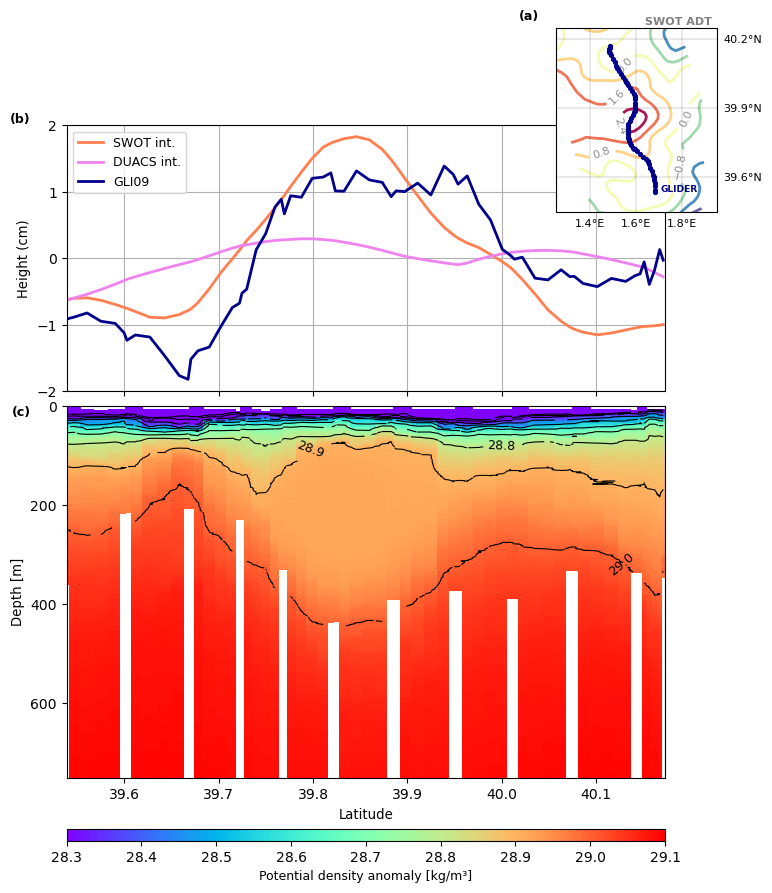

In [43]:
fig = plt.figure(figsize=(7, 8))
main_gs = fig.add_gridspec(2, 1,  height_ratios=[0.6, 1]) 

###################################################################################
# Create the first subplot (top left)
ax1 = fig.add_subplot(main_gs[0])
ax1.plot(Lat, ssh_swot_int_an * 100, c='coral', label='SWOT int.', linewidth=2)
ax1.plot(Lat, ssh_duacs_int_an * 100, c='violet', label='DUACS int.', linewidth=2)
ax1.plot(Lat, dh_an_glider * 100, c='darkblue', label='GLI09', linewidth=2)
ax1.set_ylabel('Height (cm)', fontsize=9.5)
ax1.set_ylim(-2, 2)
ax1.locator_params(axis='y', nbins=5)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.set_xlim(39.539, 40.173)
ax1.legend(fontsize=9, loc='upper left')

# Add subplot (c) as an inset within (a)
inset_ax = fig.add_axes([0.8, 0.86, 0.23, 0.23], projection=ccrs.PlateCarree())
inset_ax.set_extent([1.25, 1.95, 39.45, 40.25], ccrs.PlateCarree())

CS = inset_ax.contour(ds_SWOT.longitude, ds_SWOT.latitude, adt_swot * 100, 
                 cmap='Spectral_r', linewidths=2, alpha=0.9,  vmin = -2, vmax=2.4, levels = 8, transform=ccrs.PlateCarree())

inset_ax.scatter(Lon, Lat, 30, marker='.', c='darkblue', label='GLI09', zorder=10)
inset_ax.clabel(CS, inline=True, fontsize=8, colors='gray')

inset_ax.text(0.97, 1.06, 'SWOT ADT', transform=inset_ax.transAxes, fontsize=8, va='top', ha='right', color='gray', fontweight='bold')
inset_ax.text(0.88, 0.15, 'GLIDER', transform=inset_ax.transAxes, color='darkblue', fontweight='bold', fontsize=6.5, va='top', ha='right')

gl = inset_ax.gridlines(draw_labels=True, linewidth=0.2, color='k', alpha=0.6, linestyle='-', zorder=10)
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}
gl.top_labels = False
gl.left_labels = False

gl.ylocator = plt.MaxNLocator(3)
gl.xlocator = plt.MaxNLocator(4)

###################################################################################
# Create the second subplot (bottom left)
ax2 = fig.add_subplot(main_gs[1])
sc2 = ax2.pcolor(lat, depth, pot_dens_an.T, cmap='rainbow', vmin=28.3, vmax=29.1)
ax2.set_xlabel('Latitude', fontsize=9.5)
ax2.set_ylabel('Depth [m]', fontsize=9.5)
cbar = fig.colorbar(sc2, ax=ax2, label='Potential Density anomaly (kg/m³)', orientation='horizontal', aspect=50, pad=0.01, anchor=(0, 0.15))
cbar.set_label('Potential density anomaly [kg/m³]', fontsize=9)
ax2.set_ylim(0, 750)
ax2.locator_params(axis='y', nbins=7)
levels = np.arange(28.1, 29.2, 0.1)

levels = np.arange(28.1, 29.2, 0.1)
CS = ax2.contour(lat, depth, pot_dens_an.T, levels, colors='k', linewidths=0.8)
manual_locations = [(39.8, 100), (40.0, 70), (40.1, 400)]
ax2.clabel(CS, inline=1, fontsize=9, colors='k', manual=manual_locations)
ax2.set_xlim(39.539, 40.173)
ax2.invert_yaxis()

# Add a,b,c
ax1.text(-0.06, 1.05, '(b)', transform=ax1.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')
ax2.text(-0.06, 1, '(c)', transform=ax2.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')
inset_ax.text(-0.1, 1.1, '(a)', transform=inset_ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.subplots_adjust(hspace=0.04, wspace=0.1)

# save figure
# plt.savefig('C:/Users/ASUS/OneDrive - Universitat de les Illes Balears/grl_codes_to_publish_def_swotv2.0.1/figures_def/figure3.png',dpi=200, bbox_inches='tight')

***


## RMSD COMPUTATION

In [44]:
# compute rmsd
rmsd_duacs = np.sqrt(np.nanmean((ssh_duacs_int_an-(dh_an_glider))**2))
rmsd_duacs*100

np.float64(0.8221305587980159)

In [45]:
# compute rmsd swot
rmsd_swot = np.sqrt(np.nanmean((ssh_swot_int_an-(dh_an_glider))**2))
rmsd_swot*100

np.float64(0.6225262514272173)

In [46]:
percent_improv = 100*(rmsd_duacs - rmsd_swot)/rmsd_duacs
percent_improv

np.float64(24.27890621930259)

### BOODSTRAP


In [47]:
from scipy.stats import bootstrap

In [48]:
ssh_swot_int_an = np.array(ssh_swot_int_an)
ssh_duacs_int_an = np.array(ssh_duacs_int_an)
dh_an_glider = np.array(dh_an_glider)


**SWOT**


In [49]:
# Define RMSD function
def rmsd(gli, swot, axis=0):
    """Compute Root Mean Square Deviation (RMSD)."""
    diff = gli - swot
    return np.sqrt(np.mean(diff**2, axis=axis))

data = (dh_an_glider, ssh_swot_int_an)

# Perform bootstrap 
res = bootstrap(
    data, 
    statistic=rmsd, 
    n_resamples=1000, 
    confidence_level=0.95, 
    method='BCa',  
    paired=True,  
    random_state=42  #
)

print(f"RMSD: {rmsd(dh_an_glider, ssh_swot_int_an):.4f}")

print(f"95% Confidence Interval: {res.confidence_interval}")


RMSD: 0.0062
95% Confidence Interval: ConfidenceInterval(low=np.float64(0.005682928525198706), high=np.float64(0.006873130006475355))


In [50]:
# confidence interval
low_ci = res.confidence_interval[0]
high_ci = res.confidence_interval[1]
low_ci, high_ci

(np.float64(0.005682928525198706), np.float64(0.006873130006475355))

In [51]:
0.0062 - low_ci, high_ci - 0.0062

(np.float64(0.0005170714748012938), np.float64(0.0006731300064753551))

In [52]:
(((0.0062 - low_ci)*100) + ((high_ci - 0.0062)*100)) / 2 # error bar

np.float64(0.05951007406383244)

**DUACS**


In [53]:
# Define RMSD function 
def rmsd(gli, swot, axis=0):
    """Compute Root Mean Square Deviation (RMSD)."""
    diff = gli - swot
    return np.sqrt(np.mean(diff**2, axis=axis))

data = (dh_an_glider, ssh_duacs_int_an)

# Perform bootstrap
res = bootstrap(
    data, 
    statistic=rmsd, 
    n_resamples=1000, 
    confidence_level=0.95, 
    method='BCa',  
    paired=True,  
    random_state=42  
)

print(f"RMSD: {rmsd(dh_an_glider, ssh_duacs_int_an):.4f}")

print(f"95% Confidence Interval: {res.confidence_interval}")

RMSD: 0.0082
95% Confidence Interval: ConfidenceInterval(low=np.float64(0.0072066619595735236), high=np.float64(0.009268073189073186))


In [54]:
# low confidence interval
low_ci = res.confidence_interval[0]
high_ci = res.confidence_interval[1]
low_ci, high_ci

(np.float64(0.0072066619595735236), np.float64(0.009268073189073186))

In [55]:
0.0082 - low_ci, high_ci - 0.0082

(np.float64(0.0009933380404264771), np.float64(0.0010680731890731852))

In [56]:
(((0.0082 - low_ci)*100) + ((high_ci - 0.0082)*100)) / 2 # error bar

np.float64(0.10307056147498311)

### ESTIMATE RADIUS OF THE EDDY:

In [57]:
# find lat of min dh (left)
min_dh1 = np.nanmin(ssh_swot_int_an[(Lat > 39.6) & (Lat < 39.7)])
min_lat1 = Lat[np.where(ssh_swot_int_an == min_dh1)[0][0]]
min_lon1 = Lon[np.where(ssh_swot_int_an == min_dh1)[0][0]]
min_lat1.values

array(39.64282241)

In [58]:
# find lat of min dh (right)
min_dh2 = np.nanmin(ssh_swot_int_an)
min_lat2 = Lat[np.where(ssh_swot_int_an == min_dh2)[0][0]]
min_lon2 = Lon[np.where(ssh_swot_int_an == min_dh2)[0][0]]
min_lat2.values

array(40.1011299)

In [59]:
max_dh = np.nanmax(ssh_swot_int_an)
max_lat = Lat[np.where(ssh_swot_int_an == max_dh)[0][0]]
max_lon = Lon[np.where(ssh_swot_int_an == max_dh)[0][0]]
max_lat.values

array(39.84613655)

In [60]:
# distance between min and max lat
dist1 = gsw.distance([min_lon1,max_lon],[min_lat1,max_lat])
dist2 = gsw.distance([min_lon2,max_lon],[min_lat2,max_lat])

dist1, dist2

(array([23859.4156527]), array([28902.85629704]))

In [61]:
(dist1 + dist2)/2

array([26381.13597487])